### En base al feature importance de la notebook "Primera notebook - Score 7k public" se quitarán columnas del dataset y se explorarán más hiperparámetros

#### Las primeras líneas de código son iguales a la anterior notebook, donde se leerá el .csv, se definirán los hiperparámetros y meses con los que se hará el entrenamiento y búsqueda de hiperparámetros, y definición de las funciones a utilizar a lo largo de la notebook.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score


In [17]:
#leo el csv
df = pd.read_csv('C:/Users/Lucas/Downloads/Maestria/EyF/competencia_01_crudo.csv')

In [18]:

# calculo el periodo0 consecutivo
dsimple = df.copy()
dsimple["pos"] = range(1, len(dsimple) + 1)
dsimple["periodo0"] = (dsimple["foto_mes"] // 100) * 12 + (dsimple["foto_mes"] % 100)

# ordeno
dsimple = dsimple.sort_values(by=["numero_de_cliente", "periodo0"])

# calculo topes
periodo_ultimo = dsimple["periodo0"].max()
periodo_anteultimo = periodo_ultimo - 1

# calculo los leads de orden 1 y 2 (shift con signo negativo equivale a lead en R)
dsimple["periodo1"] = dsimple.groupby("numero_de_cliente")["periodo0"].shift(-1)
dsimple["periodo2"] = dsimple.groupby("numero_de_cliente")["periodo0"].shift(-2)

# asigno valores por defecto
dsimple["clase_ternaria"] = None
dsimple.loc[dsimple["periodo0"] < periodo_anteultimo, "clase_ternaria"] = "CONTINUA"

# calculo BAJA+1
cond_baja1 = (
    (dsimple["periodo0"] < periodo_ultimo)
    & (dsimple["periodo1"].isna() | (dsimple["periodo0"] + 1 < dsimple["periodo1"]))
)
dsimple.loc[cond_baja1, "clase_ternaria"] = "BAJA+1"

# calculo BAJA+2
cond_baja2 = (
    (dsimple["periodo0"] < periodo_anteultimo)
    & (dsimple["periodo0"] + 1 == dsimple["periodo1"])
    & (dsimple["periodo2"].isna() | (dsimple["periodo0"] + 2 < dsimple["periodo2"]))
)
dsimple.loc[cond_baja2, "clase_ternaria"] = "BAJA+2"

# vuelvo a ordenar por pos y pego al dataset original
dsimple = dsimple.sort_values(by="pos")
df["clase_ternaria"] = dsimple["clase_ternaria"].values

In [19]:
import numpy as np

# ordenar
df = df.sort_values(by=["foto_mes", "clase_ternaria", "numero_de_cliente"])

# contar registros por foto_mes y clase_ternaria
conteos = df.groupby(["foto_mes", "clase_ternaria"]).size().reset_index(name="N")


PARAM = {
    "experimento": 4940,
    "semilla_primigenia": [878787],
    "train": [202101,202102, 202103],
    "train_final": [202101, 202102, 202103,202104],
    "future": [202106],
    "semilla_kaggle": 314159,
    "cortes": list(range(6000, 19001, 500)),
    "trainingstrategy": {
        "undersampling": 0.2
    }
}




#### Agrego nuevos hiperparámetros a analizar y modifico algunos rangos en base dónde se ubicaron (si estuvieron cerca de los extremos de los rangos o no) en la primer notebook.

In [ ]:
import lightgbm as lgb


# cross validation folds
PARAM["hyperparametertuning"] = {}
PARAM["hyperparametertuning"]["xval_folds"] = 5



# parámetros fijos de LightGBM
PARAM["lgbm"] = {}
PARAM["lgbm"]["param_fijos"] = {
    "boosting_type": "gbdt",  # en python el nombre es boosting_type
    "objective": "binary",
    "metric": "auc",
    "first_metric_only": False,
    "boost_from_average": True,
    "feature_pre_filter": False,
    "force_row_wise": True,
    "verbosity": -100,

    "seed": PARAM["semilla_primigenia"],

    "max_depth": -1,
    "min_gain_to_split": 0.0,
    "min_sum_hessian_in_leaf": 0.001,
    "lambda_l1": 0.0,
    "lambda_l2": 0.0,
    "max_bin": 31,

    "bagging_fraction": 1.0,
    "pos_bagging_fraction": 1.0,
    "neg_bagging_fraction": 1.0,
    "is_unbalance": False,
    "scale_pos_weight": 1.0,

    "drop_rate": 0.1,
    "max_drop": 50,
    "skip_drop": 0.5,

    "extra_trees": False,

    "num_iterations": 1200,
    "learning_rate": 0.02,
    "feature_fraction": 0.5,
    "num_leaves": 750,
    "min_data_in_leaf": 5000,
}

# espacio de hiperparámetros (para una BO en optuna/skopt)
PARAM["hyperparametertuning"]["hs"] = {
    "num_iterations": {"type": "int", "low": 10, "high": 1500},
    "learning_rate": {"type": "float", "low": 0.01, "high": 0.3},
    "feature_fraction": {"type": "float", "low": 0.4, "high": 1.0},
    "num_leaves": {"type": "int", "low": 500, "high": 2200},
    "min_data_in_leaf": {"type": "int", "low": 1, "high": 1500},
    "max_depth": {"type": "int", "low": -1, "high": 18},
    "lambda_l1": {"type": "float", "low": 0.0, "high": 15.0},
    "lambda_l2": {"type": "float", "low": 0.0, "high": 15.0},
    "min_gain_to_split": {"type": "float", "low": 0.0, "high": 10.0},
    "bagging_fraction": {"type": "float", "low": 0.4, "high": 1.0},
    "bagging_freq": {"type": "int", "low": 1, "high": 15},
    "min_sum_hessian_in_leaf": {"type": "float", "low": 0.001, "high": 20.0},

    # Nuevos
    "boosting_type": {"type": "categorical", "choices": ["gbdt", "dart"]},
    "scale_pos_weight": {"type": "float", "low": 1.0, "high": 50.0},
    "max_bin": {"type": "int", "low": 25, "high": 100},
}






In [28]:
from sklearn.model_selection import train_test_split

def particionar(data, division, agrupa="", campo="fold", start=1, seed=None):
    data = data.copy().reset_index(drop=True)  # 🔹 reset indices
    total = sum(division)
    fracs = [d / total for d in division]  # pasar a proporciones
    bloques = list(range(start, start + len(division)))

    if agrupa:
        strat_col = data[agrupa]
    else:
        strat_col = None

    folds = np.zeros(len(data), dtype=int)
    idx = np.arange(len(data))

    for i, frac in enumerate(fracs):
        if i == len(fracs) - 1:
            chosen_idx = idx
        else:
            _, chosen_idx = train_test_split(
                idx,
                test_size=1-frac,
                stratify=strat_col.iloc[idx] if strat_col is not None else None,
                random_state=seed
            )
        folds[chosen_idx] = bloques[i]
        # actualizar lo que queda
        mask = np.isin(idx, chosen_idx, invert=True)
        idx = idx[mask]

    data[campo] = folds
    return data



In [6]:
def realidad_inicializar(pfuture, pparam):
    # datos para verificar la ganancia
    drealidad = pfuture[["numero_de_cliente", "foto_mes", "clase_ternaria"]].copy()

    drealidad = particionar(
        drealidad,
        division=[3, 7],
        agrupa="clase_ternaria",
        seed=PARAM["semilla_kaggle"]
    )
    return drealidad


In [7]:
def realidad_evaluar(prealidad, pprediccion):
    """
    Calcula la ganancia esperada.
    prealidad: DataFrame con columnas [numero_de_cliente, foto_mes, clase_ternaria, fold]
    pprediccion: DataFrame con columnas [numero_de_cliente, foto_mes, Predicted]
    """
    # merge para agregar predicciones
    merged = prealidad.merge(
        pprediccion[["numero_de_cliente", "foto_mes", "Predicted"]],
        on=["numero_de_cliente", "foto_mes"],
        how="left"
    )
    merged["predicted"] = merged["Predicted"].astype("Int64")
    merged = merged.drop(columns="Predicted")

    # tabla de conteos
    tbl = (
        merged.groupby(["fold", "predicted", "clase_ternaria"])
        .size()
        .reset_index(name="qty")
    )

    # función de ganancia
    def ganancia(subtbl):
        return (subtbl["qty"] * np.where(subtbl["clase_ternaria"]=="BAJA+2", 780000, -20000)).sum()

    res = {}
    # fold==1 → public (dividido por 0.3)
    mask_pub = (tbl["fold"]==1) & (tbl["predicted"]==1)
    res["public"] = ganancia(tbl[mask_pub]) / 0.3

    # fold==2 → private (dividido por 0.7)
    mask_priv = (tbl["fold"]==2) & (tbl["predicted"]==1)
    res["private"] = ganancia(tbl[mask_priv]) / 0.7

    # total sin dividir
    mask_total = tbl["predicted"]==1
    res["total"] = ganancia(tbl[mask_total])

    return res


#### "Normalizo" la columna mpayroll de junio multiplicando por 0,7 el valor para aquellos casos donde cobre aguinaldo el cliente.

In [20]:
# Aseguramos que la columna mpayroll sea numérica
df["mpayroll"] = pd.to_numeric(df["mpayroll"], errors="coerce")

# 1️⃣ Crear una máscara de clientes que tienen mpayroll no nulo en 202105 y 202106
clientes_validos = df.query("foto_mes in [202105, 202106]") \
    .pivot(index="numero_de_cliente", columns="foto_mes", values="mpayroll") \
    .dropna(subset=[202105, 202106]) \
    .index

# 2️⃣ Copiar mpayroll a una nueva columna
df["mpayroll_norm"] = df["mpayroll"]

# 3️⃣ Aplicar la normalización (multiplicar por 0.7 solo en 202106 y clientes válidos)
mask = (df["foto_mes"] == 202106) & (df["numero_de_cliente"].isin(clientes_validos))
df.loc[mask, "mpayroll_norm"] = df.loc[mask, "mpayroll"] * 0.7

#### Armo ranking de columnas monetarias

In [21]:
def rank_separate_group(df, columns, group_col="foto_mes"):
    """
    Genera columnas *_ranked por cada variable monetaria,
    aplicando ranking separado por signo y por grupo temporal (foto_mes),
    tolerante a NaN.
    """
    df = df.copy()

    for col in columns:
        new_col = f"{col}_ranked"
        df[new_col] = np.nan  # inicializa la columna

        def rank_group(g):
            s = g[col]
            ranked = pd.Series(index=s.index, dtype=float)

            # negativos
            mask_neg = (s < 0) & s.notna()
            if mask_neg.any():
                ranked.loc[mask_neg] = -s[mask_neg].rank(method="average", ascending=False)

            # positivos
            mask_pos = (s > 0) & s.notna()
            if mask_pos.any():
                ranked.loc[mask_pos] = s[mask_pos].rank(method="average", ascending=True)

            # ceros
            mask_zero = (s == 0) & s.notna()
            if mask_zero.any():
                ranked.loc[mask_zero] = 0

            return ranked

        # aplicar ranking solo a filas válidas del grupo
        ranked_series = df.groupby(group_col, group_keys=False).apply(rank_group)
        df.loc[ranked_series.index, new_col] = ranked_series

    return df


cols_monetarias = [
    "mrentabilidad", "mrentabilidad_annual", "mcomisiones", "mactivos_margen", "mpasivos_margen", 
    "mcuenta_corriente_adicional", "mcuenta_corriente", "mcaja_ahorro", "mcaja_ahorro_adicional", 
    "mcaja_ahorro_dolares", "mcuentas_saldo", "mautoservicio", "mtarjeta_visa_consumo", "mtarjeta_master_consumo", 
    "mprestamos_personales", "mprestamos_prendarios", "mprestamos_hipotecarios", "mplazo_fijo_dolares", 
    "mplazo_fijo_pesos", "minversion1_pesos", "minversion1_dolares", "minversion2", "mpayroll", "mpayroll2", 
    "mcuenta_debitos_automaticos", "mttarjeta_visa_debitos_automaticos", "mttarjeta_master_debitos_automaticos", 
    "mpagodeservicios", "mpagomiscuentas", "mcajeros_propios_descuentos", "mtarjeta_visa_descuentos", 
    "mtarjeta_master_descuentos", "mcomisiones_mantenimiento", "mcomisiones_otras", "mforex_buy", "mforex_sell", 
    "mtransferencias_recibidas", "mtransferencias_emitidas", "mextraccion_autoservicio", "mcheques_depositados", 
    "mcheques_emitidos", "mcheques_depositados_rechazados", "mcheques_emitidos_rechazados", "matm", "matm_other", 
    "Master_mfinanciacion_limite", "Master_msaldototal", "Master_msaldopesos", "Master_msaldodolares", 
    "Master_mconsumospesos", "Master_mconsumosdolares", "Master_mlimitecompra", "Master_madelantopesos", 
    "Master_madelantodolares", "Master_mpagado", "Master_mpagospesos", "Master_mpagosdolares", 
    "Master_mconsumototal", "Master_mpagominimo", "Visa_mfinanciacion_limite", "Visa_msaldototal", 
    "Visa_msaldopesos", "Visa_msaldodolares", "Visa_mconsumospesos", "Visa_mconsumosdolares", 
    "Visa_mlimitecompra", "Visa_madelantopesos", "Visa_madelantodolares", "Visa_mpagado", "Visa_mpagospesos", 
    "Visa_mpagosdolares", "Visa_mconsumototal", "Visa_mpagominimo","mpayroll_norm"
]

# aplicar ranking neutralizado por mes
df = rank_separate_group(df, cols_monetarias)

#### Hago columnas con lag y delta lag de orden 1 y 2 de todas las columnas salvo numero de cliente, foto mes y clase ternaria.

In [ ]:
# --- 0️⃣ Preparación ---
df = df.sort_values(["numero_de_cliente", "foto_mes"])

# columnas a excluir
excluir = {"numero_de_cliente", "foto_mes", "clase_ternaria"}
columnas = [c for c in df.columns if c not in excluir]

# --- 1️⃣ Generar lag y delta de orden 1 y 2 ---
for col in columnas:
    for lag in [1, 2]:
        df[f"{col}_lag{lag}"] = df.groupby("numero_de_cliente")[col].shift(lag)
        df[f"{col}_delta{lag}"] = df[col] - df[f"{col}_lag{lag}"]


In [23]:
#me dejo una copia por si falla algo así no tengo que correr todo de vuelta
dft=df.copy()

##### Saco las features no importantes (hasta 100 de importancia) que obtuve de la primer notebook

In [24]:
# === Feature importance filtering ===
archivo_importancia = r"C:\Users\Lucas\Proyectos cursor\Exp12\feature_importance_primer_notebook.txt"
features_df = pd.read_csv(archivo_importancia, sep="\t")

# Filtrar features con importancia >= 100
features_filtradas = features_df.loc[features_df["Importance"] >= 10, "Feature"].tolist()

# Columnas extra que no deben perderse
cols_extra = ["clase_ternaria","foto_mes"]

# Crear el dataframe filtrado
df_filtrado = df[cols_extra + [c for c in features_filtradas if c in df.columns]].copy()

In [25]:
df=df_filtrado.copy()

#### Genero el dataset train a partir de los meses seleccionados al inicio

In [26]:
# 1️⃣ Filtrar por meses de training
dataset_train = df[df["foto_mes"].isin(PARAM["train"])].copy()

# 2️⃣ Clase binaria
dataset_train["clase01"] = np.where(
    dataset_train["clase_ternaria"].isin(["BAJA+1", "BAJA+2"]), 1, 0
)

# 3️⃣ Undersampling de CONTINUA
np.random.seed(PARAM["semilla_primigenia"][0])  # recordá que es lista
dataset_train["azar"] = np.random.rand(len(dataset_train))
mask_training = (
    (dataset_train["foto_mes"].isin(PARAM["train"])) &
    ((dataset_train["azar"] <= PARAM["trainingstrategy"]["undersampling"]) |
     (dataset_train["clase_ternaria"].isin(["BAJA+1", "BAJA+2"])))
)
dataset_train = dataset_train.loc[mask_training].copy()

# 4️⃣ Seleccionar columnas a usar
campos_buenos = dataset_train.columns.difference(
    ["clase_ternaria", "clase01", "azar"]
)

X_train = dataset_train[campos_buenos].copy()
y_train = dataset_train["clase01"].copy()

# 5️⃣ Convertir categóricas a numéricas si las hay
for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = X_train[col].astype('category').cat.codes

# 6️⃣ Asegurar tipos correctos para LightGBM
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.int32)

# ✅ Listo para usar en Optuna
print("Shape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)
print("Balance clases:\n", y_train.value_counts())



Shape X_train: (101496, 375)
Shape y_train: (101496,)
Balance clases:
 clase01
0    96196
1     5300
Name: count, dtype: int64


##### Defino función de estimar ganancia e indico los hiperparámetros y los rangos tal cual los definí al inicio

In [29]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

# Semilla
seed = 878787
seeds = [seed]

# Función de Optuna para estimar AUC con CV
def EstimarGanancia_AUC_lightgbm(trial, X, y, seeds):
    aucs_semillas = []

    for seed in seeds:
        param = {
            # Configs fijas
            "objective": "binary",
            "metric": "auc",
            "verbosity": -1,
            "seed": seed,

            # Hiperparámetros a tunear
            "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
            "num_iterations": trial.suggest_int("num_iterations", 10, 1500),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "num_leaves": trial.suggest_int("num_leaves", 500, 2200),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
            "max_depth": trial.suggest_int("max_depth", -1, 18),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 1500),
            "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 15.0),
            "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 15.0),
            "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 10.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 15),
            "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 0.001, 20.0),

            # Nuevos sugeridos
            "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 50.0),
            "max_bin": trial.suggest_int("max_bin", 25, 100),
        }



        cv = StratifiedKFold(
            n_splits=PARAM["hyperparametertuning"]["xval_folds"],
            shuffle=True,
            random_state=seed
        )

        aucs = []
        for train_idx, valid_idx in cv.split(X, y):
            lgb_train = lgb.Dataset(X.iloc[train_idx].astype(np.float32), label=y.iloc[train_idx].astype(np.int32))
            lgb_valid = lgb.Dataset(X.iloc[valid_idx].astype(np.float32), label=y.iloc[valid_idx].astype(np.int32))

            model = lgb.train(
                param,
                lgb_train,
                valid_sets=[lgb_valid],
                callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
            )
            preds = model.predict(X.iloc[valid_idx])
            auc = roc_auc_score(y.iloc[valid_idx], preds)
            aucs.append(auc)

        aucs_semillas.append(np.mean(aucs))

    return np.mean(aucs_semillas)



C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Realizo la optimización bayesiana, primero con 25 trials random y luego con 35 TPESampler

In [30]:

# Crear el estudio
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.RandomSampler(seed=seed)
)

# Primeras 20 pruebas random
study.optimize(
    lambda trial: EstimarGanancia_AUC_lightgbm(trial, X_train, y_train, seeds),
    n_trials=25
)

# Luego 30 pruebas con TPE
study.sampler = optuna.samplers.TPESampler(seed=seed)
study.optimize(
    lambda trial: EstimarGanancia_AUC_lightgbm(trial, X_train, y_train, seeds),
    n_trials=35
)

# Guardar resultados
tb_bayesiana = study.trials_dataframe(attrs=("number", "value", "params", "state")).rename(columns={"value": "AUC"})
tb_bayesiana["iter"] = tb_bayesiana.index + 1
tb_bayesiana.sort_values(by="AUC", ascending=False).to_csv("BO_log.txt", sep="\t", index=False)

PARAM["out"] = {
    "lgbm": {
        "mejores_hiperparametros": study.best_trial.params,
        "AUC": study.best_trial.value
    }
}
print("✅ Mejores hiperparámetros:", study.best_trial.params)
print("✅ Mejor AUC:", study.best_trial.value)




[I 2025-10-09 17:43:41,209] A new study created in memory with name: no-name-e49acb07-bf8e-4a97-831c-def26d9844ee


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[153]	valid_0's auc: 0.934259
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[286]	valid_0's auc: 0.93893
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[113]	valid_0's auc: 0.924586
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[237]	valid_0's auc: 0.931972
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[206]	valid_0's auc: 0.937233


[I 2025-10-09 17:44:13,461] Trial 0 finished with value: 0.9333960566045505 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 792, 'learning_rate': 0.12225517684754826, 'num_leaves': 1737, 'feature_fraction': 0.5474910314574816, 'max_depth': 9, 'min_data_in_leaf': 699, 'lambda_l1': 11.364219835973833, 'lambda_l2': 10.587416170941841, 'min_gain_to_split': 9.31713699079583, 'bagging_fraction': 0.8497372222417328, 'bagging_freq': 5, 'min_sum_hessian_in_leaf': 0.7384833885205929, 'scale_pos_weight': 26.29157771380609, 'max_bin': 82}. Best is trial 0 with value: 0.9333960566045505.
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Pytho

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	valid_0's auc: 0.93117
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	valid_0's auc: 0.933147
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	valid_0's auc: 0.92361
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[126]	valid_0's auc: 0.931335
Training until validation scores don't improve for 50 rounds


[I 2025-10-09 17:54:13,723] Trial 3 finished with value: 0.9308308002502311 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 344, 'learning_rate': 0.19751552165303163, 'num_leaves': 1360, 'feature_fraction': 0.9884991998440884, 'max_depth': 18, 'min_data_in_leaf': 228, 'lambda_l1': 3.7874830689391676, 'lambda_l2': 10.531878052720483, 'min_gain_to_split': 4.195709152358756, 'bagging_fraction': 0.7353577602300094, 'bagging_freq': 12, 'min_sum_hessian_in_leaf': 16.702865306562057, 'scale_pos_weight': 42.32516657436609, 'max_bin': 56}. Best is trial 2 with value: 0.9355306790906649.


Early stopping, best iteration is:
[93]	valid_0's auc: 0.934892
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[167]	valid_0's auc: 0.924762
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[302]	valid_0's auc: 0.930719
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[314]	valid_0's auc: 0.918613
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[216]	valid_0's auc: 0.923555
Training until validation scores don't improve for 50 rounds


[I 2025-10-09 17:54:25,499] Trial 4 finished with value: 0.9252587192900714 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 1244, 'learning_rate': 0.23759189065873848, 'num_leaves': 1064, 'feature_fraction': 0.8606159362039743, 'max_depth': 2, 'min_data_in_leaf': 1215, 'lambda_l1': 9.065860731493368, 'lambda_l2': 14.439747590356081, 'min_gain_to_split': 3.032701364415259, 'bagging_fraction': 0.4242177341316495, 'bagging_freq': 3, 'min_sum_hessian_in_leaf': 9.485769957819821, 'scale_pos_weight': 47.81294957717391, 'max_bin': 32}. Best is trial 2 with value: 0.9355306790906649.


Early stopping, best iteration is:
[116]	valid_0's auc: 0.928644
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[254]	valid_0's auc: 0.932119
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[147]	valid_0's auc: 0.935253
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[234]	valid_0's auc: 0.925601
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[282]	valid_0's auc: 0.932558
Training until validation scores don't improve for 50 rounds


[I 2025-10-09 17:54:45,968] Trial 5 finished with value: 0.93195536340431 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 1259, 'learning_rate': 0.12457339613690484, 'num_leaves': 1088, 'feature_fraction': 0.8452703104159863, 'max_depth': 17, 'min_data_in_leaf': 1281, 'lambda_l1': 11.872316603351297, 'lambda_l2': 0.6106391887910373, 'min_gain_to_split': 0.9627147993500484, 'bagging_fraction': 0.5065580786614856, 'bagging_freq': 14, 'min_sum_hessian_in_leaf': 12.058302711586734, 'scale_pos_weight': 37.20409755596174, 'max_bin': 26}. Best is trial 2 with value: 0.9355306790906649.


Early stopping, best iteration is:
[159]	valid_0's auc: 0.934245
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[182]	valid_0's auc: 0.929252
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[129]	valid_0's auc: 0.934966
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[170]	valid_0's auc: 0.924155
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[103]	valid_0's auc: 0.928345
Training until validation scores don't improve for 50 rounds


[I 2025-10-09 17:55:09,005] Trial 6 finished with value: 0.9299289865477606 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 561, 'learning_rate': 0.17618322853587112, 'num_leaves': 1020, 'feature_fraction': 0.4503064350260201, 'max_depth': 12, 'min_data_in_leaf': 1165, 'lambda_l1': 6.599835547629789, 'lambda_l2': 5.693796896366364, 'min_gain_to_split': 6.390210091583545, 'bagging_fraction': 0.6542302674616324, 'bagging_freq': 10, 'min_sum_hessian_in_leaf': 16.651300551238236, 'scale_pos_weight': 3.5822215146159495, 'max_bin': 67}. Best is trial 2 with value: 0.9355306790906649.


Early stopping, best iteration is:
[112]	valid_0's auc: 0.932926


C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lig

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	valid_0's auc: 0.931599
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[138]	valid_0's auc: 0.93607
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[147]	valid_0's auc: 0.923892
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[167]	valid_0's auc: 0.929699
Training until validation scores don't improve for 50 rounds


[I 2025-10-09 17:58:13,285] Trial 8 finished with value: 0.9308078912561987 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 1280, 'learning_rate': 0.16474011352884363, 'num_leaves': 1124, 'feature_fraction': 0.49795562034944985, 'max_depth': 8, 'min_data_in_leaf': 768, 'lambda_l1': 10.85797181107384, 'lambda_l2': 6.817124627571395, 'min_gain_to_split': 8.904750409915994, 'bagging_fraction': 0.6647726140450444, 'bagging_freq': 6, 'min_sum_hessian_in_leaf': 5.694443131770792, 'scale_pos_weight': 17.61632226539379, 'max_bin': 70}. Best is trial 2 with value: 0.9355306790906649.


Early stopping, best iteration is:
[54]	valid_0's auc: 0.93278


C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lig

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[756]	valid_0's auc: 0.93952
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[686]	valid_0's auc: 0.943896
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[806]	valid_0's auc: 0.933885
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[739]	valid_0's auc: 0.939529
Training until validation scores don't improve for 50 rounds


[I 2025-10-09 18:04:46,760] Trial 10 finished with value: 0.9388896091458069 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 816, 'learning_rate': 0.0630946452762805, 'num_leaves': 1560, 'feature_fraction': 0.907593977727425, 'max_depth': 14, 'min_data_in_leaf': 134, 'lambda_l1': 0.8781329101264995, 'lambda_l2': 2.891694136024892, 'min_gain_to_split': 0.020750712643884395, 'bagging_fraction': 0.9434327601296862, 'bagging_freq': 12, 'min_sum_hessian_in_leaf': 3.434389185185518, 'scale_pos_weight': 21.88266235984722, 'max_bin': 44}. Best is trial 10 with value: 0.9388896091458069.


Early stopping, best iteration is:
[117]	valid_0's auc: 0.937618


C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lig

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.922743
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.925756
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.916476
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.923158
Training until validation scores don't improve for 50 rounds


[I 2025-10-09 18:08:04,134] Trial 13 finished with value: 0.9230627047095542 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 34, 'learning_rate': 0.013204299589175392, 'num_leaves': 1085, 'feature_fraction': 0.6089721087759206, 'max_depth': 13, 'min_data_in_leaf': 44, 'lambda_l1': 13.643759952578618, 'lambda_l2': 10.265750772333572, 'min_gain_to_split': 5.5635466473467785, 'bagging_fraction': 0.9819878900428428, 'bagging_freq': 3, 'min_sum_hessian_in_leaf': 3.44160237782896, 'scale_pos_weight': 13.101766139039928, 'max_bin': 90}. Best is trial 10 with value: 0.9388896091458069.


Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.92718
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[193]	valid_0's auc: 0.927713
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[164]	valid_0's auc: 0.932792
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[122]	valid_0's auc: 0.918804
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[220]	valid_0's auc: 0.923134
Training until validation scores don't improve for 50 rounds


[I 2025-10-09 18:08:33,886] Trial 14 finished with value: 0.9262814833140249 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 814, 'learning_rate': 0.26248442960634205, 'num_leaves': 990, 'feature_fraction': 0.5608673800727105, 'max_depth': 5, 'min_data_in_leaf': 494, 'lambda_l1': 4.290298426538628, 'lambda_l2': 5.707085873226939, 'min_gain_to_split': 1.4456340981578475, 'bagging_fraction': 0.6484300119474493, 'bagging_freq': 15, 'min_sum_hessian_in_leaf': 7.62823083560018, 'scale_pos_weight': 46.611112238251835, 'max_bin': 88}. Best is trial 10 with value: 0.9388896091458069.


Early stopping, best iteration is:
[131]	valid_0's auc: 0.928965
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[213]	valid_0's auc: 0.932727
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[158]	valid_0's auc: 0.935048
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[176]	valid_0's auc: 0.924613
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	valid_0's auc: 0.928092
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[199]	valid_0's auc: 0.935242


[I 2025-10-09 18:08:53,036] Trial 15 finished with value: 0.9311445090379443 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 553, 'learning_rate': 0.1778702319437598, 'num_leaves': 1965, 'feature_fraction': 0.6841734786382347, 'max_depth': 5, 'min_data_in_leaf': 878, 'lambda_l1': 7.40855931060639, 'lambda_l2': 1.2361601485154594, 'min_gain_to_split': 2.693711768675083, 'bagging_fraction': 0.9522200012091353, 'bagging_freq': 14, 'min_sum_hessian_in_leaf': 0.6190728668902801, 'scale_pos_weight': 38.443876855763655, 'max_bin': 35}. Best is trial 10 with value: 0.9388896091458069.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[227]	valid_0's auc: 0.935038
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[265]	valid_0's auc: 0.938491
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[272]	valid_0's auc: 0.927744
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[217]	valid_0's auc: 0.932752
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[204]	valid_0's auc: 0.938986


[I 2025-10-09 18:09:39,329] Trial 16 finished with value: 0.9346023540975967 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 698, 'learning_rate': 0.08851155315299494, 'num_leaves': 1125, 'feature_fraction': 0.4926157443464741, 'max_depth': 17, 'min_data_in_leaf': 386, 'lambda_l1': 8.577108434080671, 'lambda_l2': 4.973115598932738, 'min_gain_to_split': 7.3580105475108475, 'bagging_fraction': 0.6537044159804061, 'bagging_freq': 11, 'min_sum_hessian_in_leaf': 11.078147557968125, 'scale_pos_weight': 38.10617302475576, 'max_bin': 89}. Best is trial 10 with value: 0.9388896091458069.
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\P

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[384]	valid_0's auc: 0.92951
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[175]	valid_0's auc: 0.931106
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[130]	valid_0's auc: 0.919163
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[147]	valid_0's auc: 0.925719
Training until validation scores don't improve for 50 rounds


[I 2025-10-09 18:28:51,010] Trial 23 finished with value: 0.9267461457409027 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 825, 'learning_rate': 0.1602575365499321, 'num_leaves': 712, 'feature_fraction': 0.7653096224995828, 'max_depth': 5, 'min_data_in_leaf': 711, 'lambda_l1': 5.949826156627805, 'lambda_l2': 1.8265318459653235, 'min_gain_to_split': 9.621802421590122, 'bagging_fraction': 0.4574437250721757, 'bagging_freq': 12, 'min_sum_hessian_in_leaf': 17.9215880113613, 'scale_pos_weight': 47.23629646261154, 'max_bin': 36}. Best is trial 10 with value: 0.9388896091458069.


Early stopping, best iteration is:
[122]	valid_0's auc: 0.928233
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[182]	valid_0's auc: 0.922526
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[142]	valid_0's auc: 0.929282
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[120]	valid_0's auc: 0.915439
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[222]	valid_0's auc: 0.923082
Training until validation scores don't improve for 50 rounds


[I 2025-10-09 18:29:14,592] Trial 24 finished with value: 0.9232110200944141 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 1123, 'learning_rate': 0.2863105716966383, 'num_leaves': 1362, 'feature_fraction': 0.4244377976220986, 'max_depth': 3, 'min_data_in_leaf': 477, 'lambda_l1': 4.649708241398461, 'lambda_l2': 7.110296901433986, 'min_gain_to_split': 7.360504005379209, 'bagging_fraction': 0.40883223484014525, 'bagging_freq': 3, 'min_sum_hessian_in_leaf': 19.80038011703333, 'scale_pos_weight': 32.08319965262398, 'max_bin': 100}. Best is trial 10 with value: 0.9388896091458069.


Early stopping, best iteration is:
[91]	valid_0's auc: 0.925726


C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lig

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[273]	valid_0's auc: 0.934516
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[272]	valid_0's auc: 0.941799
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[278]	valid_0's auc: 0.931348
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	valid_0's auc: 0.933611
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[102]	valid_0's auc: 0.939985


[I 2025-10-09 19:33:56,836] Trial 37 finished with value: 0.9362515155787673 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 731, 'learning_rate': 0.07492891978732502, 'num_leaves': 1632, 'feature_fraction': 0.9627029348941992, 'max_depth': 17, 'min_data_in_leaf': 306, 'lambda_l1': 0.09565375279955668, 'lambda_l2': 9.435443707313299, 'min_gain_to_split': 3.6538318352840777, 'bagging_fraction': 0.8912766609649494, 'bagging_freq': 9, 'min_sum_hessian_in_leaf': 10.254255482364718, 'scale_pos_weight': 18.033184004360255, 'max_bin': 45}. Best is trial 10 with value: 0.9388896091458069.
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[143]	valid_0's auc: 0.928111
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[176]	valid_0's auc: 0.933855
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[252]	valid_0's auc: 0.924668
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[169]	valid_0's auc: 0.930399
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[151]	valid_0's auc: 0.932182


[I 2025-10-09 19:38:31,198] Trial 39 finished with value: 0.9298430978134935 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 641, 'learning_rate': 0.13952725738511745, 'num_leaves': 1236, 'feature_fraction': 0.9727449631824305, 'max_depth': 16, 'min_data_in_leaf': 14, 'lambda_l1': 3.3423441909256755, 'lambda_l2': 7.647556988643133, 'min_gain_to_split': 2.211235404302432, 'bagging_fraction': 0.5845119580086998, 'bagging_freq': 11, 'min_sum_hessian_in_leaf': 6.006161192372131, 'scale_pos_weight': 24.553420510458423, 'max_bin': 58}. Best is trial 38 with value: 0.9389468325272233.
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Py

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[260]	valid_0's auc: 0.936532
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[285]	valid_0's auc: 0.939788
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[295]	valid_0's auc: 0.929337
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[224]	valid_0's auc: 0.935641
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[274]	valid_0's auc: 0.940283


[I 2025-10-09 20:03:28,904] Trial 46 finished with value: 0.9363158979965753 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 620, 'learning_rate': 0.07386772200669087, 'num_leaves': 2137, 'feature_fraction': 0.9550675627631369, 'max_depth': 14, 'min_data_in_leaf': 266, 'lambda_l1': 3.2849413152829765, 'lambda_l2': 1.8395776649117555, 'min_gain_to_split': 2.174130915959394, 'bagging_fraction': 0.8263706416014525, 'bagging_freq': 10, 'min_sum_hessian_in_leaf': 12.512417682843756, 'scale_pos_weight': 16.22631880379226, 'max_bin': 49}. Best is trial 44 with value: 0.9392761711638616.
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[186]	valid_0's auc: 0.932277
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[144]	valid_0's auc: 0.935824
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[226]	valid_0's auc: 0.926553
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[259]	valid_0's auc: 0.932093
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[184]	valid_0's auc: 0.934335


[I 2025-10-09 20:07:27,739] Trial 48 finished with value: 0.9322164470032119 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 544, 'learning_rate': 0.1468676563811055, 'num_leaves': 1712, 'feature_fraction': 0.8379134934414691, 'max_depth': 18, 'min_data_in_leaf': 70, 'lambda_l1': 0.960163520640648, 'lambda_l2': 12.999016067425444, 'min_gain_to_split': 2.425189822252701, 'bagging_fraction': 0.6785497307571356, 'bagging_freq': 13, 'min_sum_hessian_in_leaf': 15.80093139576012, 'scale_pos_weight': 26.25237895028503, 'max_bin': 60}. Best is trial 44 with value: 0.9392761711638616.
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Pyth

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's auc: 0.934322
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	valid_0's auc: 0.936354
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	valid_0's auc: 0.929287
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	valid_0's auc: 0.932665
Training until validation scores don't improve for 50 rounds


[I 2025-10-09 20:09:22,452] Trial 50 finished with value: 0.933795686418166 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 342, 'learning_rate': 0.182294333453705, 'num_leaves': 1231, 'feature_fraction': 0.9190709104294247, 'max_depth': 11, 'min_data_in_leaf': 85, 'lambda_l1': 7.234261614917115, 'lambda_l2': 10.013350551369133, 'min_gain_to_split': 1.5729498346838224, 'bagging_fraction': 0.9989774182217335, 'bagging_freq': 12, 'min_sum_hessian_in_leaf': 6.572069732065174, 'scale_pos_weight': 6.290553111174944, 'max_bin': 54}. Best is trial 44 with value: 0.9392761711638616.


Early stopping, best iteration is:
[74]	valid_0's auc: 0.93635


C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lig

✅ Mejores hiperparámetros: {'boosting_type': 'dart', 'num_iterations': 649, 'learning_rate': 0.11524398867697595, 'num_leaves': 1860, 'feature_fraction': 0.9795332454292214, 'max_depth': 17, 'min_data_in_leaf': 7, 'lambda_l1': 2.270616389907379, 'lambda_l2': 1.3592847823243908, 'min_gain_to_split': 0.9621865293811875, 'bagging_fraction': 0.9313861381547075, 'bagging_freq': 14, 'min_sum_hessian_in_leaf': 1.8791281129840096, 'scale_pos_weight': 4.070876512790485, 'max_bin': 40}
✅ Mejor AUC: 0.9405360493092945


In [31]:
tb_bayesiana = study.trials_dataframe(attrs=("number", "value", "params", "state"))
tb_bayesiana = tb_bayesiana.rename(columns={"value": "y"})
tb_bayesiana["iter"] = tb_bayesiana.index + 1
tb_bayesiana = tb_bayesiana.sort_values(by="y", ascending=False).reset_index(drop=True)
tb_bayesiana.to_csv("BO_log.txt", sep="\t", index=False)
mejores_hiperparametros = study.best_trial.params
mejor_auc = study.best_trial.value
print("Mejores hiperparámetros:", mejores_hiperparametros)
print("Mejor AUC:", mejor_auc)
PARAM["out"] = {"lgbm": {"mejores_hiperparametros": mejores_hiperparametros, "y": mejor_auc}}


Mejores hiperparámetros: {'boosting_type': 'dart', 'num_iterations': 649, 'learning_rate': 0.11524398867697595, 'num_leaves': 1860, 'feature_fraction': 0.9795332454292214, 'max_depth': 17, 'min_data_in_leaf': 7, 'lambda_l1': 2.270616389907379, 'lambda_l2': 1.3592847823243908, 'min_gain_to_split': 0.9621865293811875, 'bagging_fraction': 0.9313861381547075, 'bagging_freq': 14, 'min_sum_hessian_in_leaf': 1.8791281129840096, 'scale_pos_weight': 4.070876512790485, 'max_bin': 40}
Mejor AUC: 0.9405360493092945


In [32]:
import yaml

# 1. Guardar PARAM en YAML
with open("C:/Users/Lucas/Proyectos cursor/Exp13/PARAM_7k_featureExt.yml", "w") as f:
    yaml.dump(PARAM, f, default_flow_style=False, sort_keys=False)

# 2. Imprimir los mejores hiperparámetros
print(PARAM["out"]["lgbm"]["mejores_hiperparametros"])

# 3. Imprimir el mejor AUC
print(PARAM["out"]["lgbm"]["y"])

{'boosting_type': 'dart', 'num_iterations': 649, 'learning_rate': 0.11524398867697595, 'num_leaves': 1860, 'feature_fraction': 0.9795332454292214, 'max_depth': 17, 'min_data_in_leaf': 7, 'lambda_l1': 2.270616389907379, 'lambda_l2': 1.3592847823243908, 'min_gain_to_split': 0.9621865293811875, 'bagging_fraction': 0.9313861381547075, 'bagging_freq': 14, 'min_sum_hessian_in_leaf': 1.8791281129840096, 'scale_pos_weight': 4.070876512790485, 'max_bin': 40}
0.9405360493092945


In [33]:
import os

# 1. Carpeta del experimento
# 1. Ruta base de experimentos
base_dir = "C:/Users/Lucas/Proyectos cursor/Exp13/exp7k_featureExt"

# 2. Carpeta del experimento
experimento = f"exp{PARAM['experimento']}"
exp_dir = os.path.join(base_dir, experimento)

# 3. Crear carpeta si no existe
os.makedirs(exp_dir, exist_ok=True)

# 4. Cambiar el cwd a esa carpeta
os.chdir(exp_dir)


In [34]:

# 2. Crear variable clase01
df["clase01"] = np.where(
    df["clase_ternaria"].isin(["BAJA+1", "BAJA+2"]), 1, 0
)



In [35]:
# Entrenamiento para evaluar en 202104
dataset_train_eval = df[df["foto_mes"].isin([202101, 202102, 202103])].copy()
dataset_test_eval  = df[df["foto_mes"] == 202104].copy()

# X_train / y_train
X_train_eval = dataset_train_eval[campos_buenos].apply(pd.to_numeric, errors="coerce").fillna(0)
y_train_eval = np.where(dataset_train_eval["clase_ternaria"].isin(["BAJA+1","BAJA+2"]), 1, 0)

# X_test / y_test
X_test_eval = dataset_test_eval[campos_buenos].apply(pd.to_numeric, errors="coerce").fillna(0)
y_test_eval = np.where(dataset_test_eval["clase_ternaria"].isin(["BAJA+1","BAJA+2"]), 1, 0)



#### Funciones para ver el comportamiento de los hiperparámetros en base a resultados de los trials

In [36]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# 1️⃣ Historial de optimización (objetivo vs trial)
fig1 = plot_optimization_history(study)
fig1.show()

# 2️⃣ Importancia de cada hiperparámetro
fig2 = plot_param_importances(study)
fig2.show()

# 3️⃣ Coordenadas paralelas: cada línea es un trial
fig3 = plot_parallel_coordinate(study)
fig3.show()

# 4️⃣ Slice plot: distribuciones de score vs valor de cada hiperparámetro
fig4 = plot_slice(study)
fig4.show()

#### Entreno con los meses 01,02 y 03 y testeo 04 y analizo, para cada semilla, la ganancia en función de la cantidad de envíos.

Entrenando modelo con seed = 878787 (evaluación 202104)
Entrenando modelo con seed = 131213 (evaluación 202104)
Entrenando modelo con seed = 999199 (evaluación 202104)
Entrenando modelo con seed = 611033 (evaluación 202104)
Entrenando modelo con seed = 100129 (evaluación 202104)
Entrenando modelo con seed = 278787 (evaluación 202104)
Entrenando modelo con seed = 991999 (evaluación 202104)
Entrenando modelo con seed = 378399 (evaluación 202104)

Seed 878787 (envíos 6000-19000):
Total ganancia: -31220000
Público (BAJA+2): 223080000
Privado (otros): -254300000

Seed 131213 (envíos 6000-19000):
Total ganancia: -40020000
Público (BAJA+2): 214500000
Privado (otros): -254520000

Seed 999199 (envíos 6000-19000):
Total ganancia: -31220000
Público (BAJA+2): 223080000
Privado (otros): -254300000

Seed 611033 (envíos 6000-19000):
Total ganancia: -25620000
Público (BAJA+2): 228540000
Privado (otros): -254160000

Seed 100129 (envíos 6000-19000):
Total ganancia: -40020000
Público (BAJA+2): 214500000


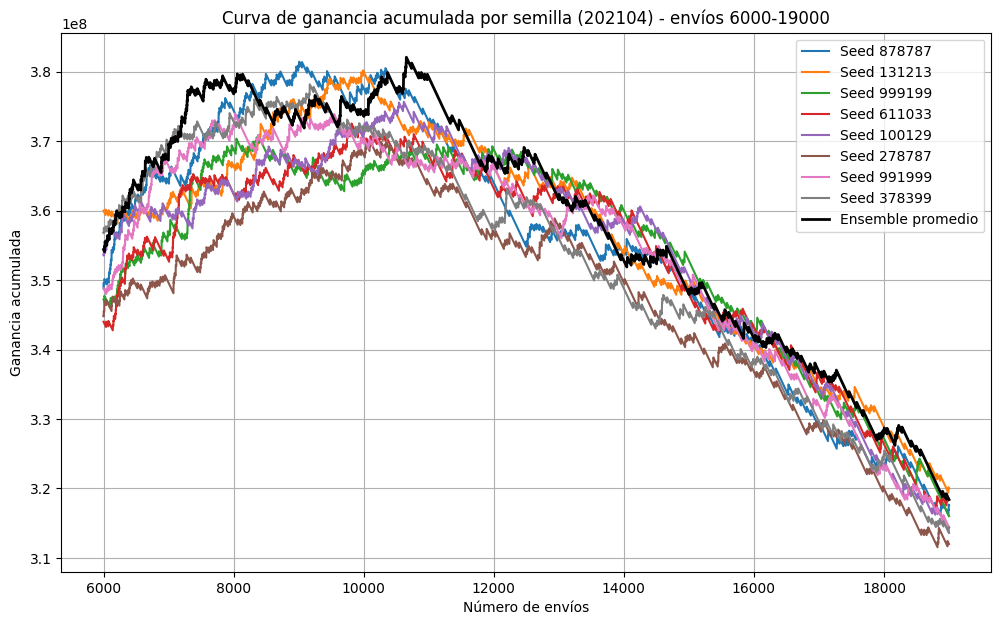

In [37]:
import matplotlib.pyplot as plt
import copy

SEEDS = [878787, 131213, 999199, 611033, 100129,278787,991999,378399]
MAX_ENVIOS = 40000  # límite de envíos
RANGO_ENV = (6000, 19000)  # rango que queremos visualizar

# --------------------------
# 1️⃣ Preparar datasets
# --------------------------
dataset_train_eval = df[df["foto_mes"].isin([202101, 202102, 202103])].copy()
X_train_eval = dataset_train_eval[campos_buenos].apply(pd.to_numeric, errors="coerce").fillna(0)
y_train_eval = np.where(dataset_train_eval["clase_ternaria"].isin(["BAJA+1","BAJA+2"]), 1, 0)

dataset_test_eval = df[df["foto_mes"] == 202104].copy()
X_test_eval = dataset_test_eval[campos_buenos].apply(pd.to_numeric, errors="coerce").fillna(0)

# --------------------------
# 2️⃣ Preparar parámetros finales
# --------------------------
param_final = PARAM["lgbm"]["param_fijos"].copy()
param_final.update(PARAM["out"]["lgbm"]["mejores_hiperparametros"])
param_normalizado = copy.deepcopy(param_final)
param_normalizado["min_data_in_leaf"] = int(round(
    param_final["min_data_in_leaf"] / PARAM["trainingstrategy"]["undersampling"]
))

# --------------------------
# 3️⃣ Entrenamiento ensemble
# --------------------------
modelos_eval = []
preds_ensemble_eval = np.zeros(len(dataset_test_eval))

for seed in SEEDS:
    params_seed = copy.deepcopy(param_normalizado)
    params_seed["seed"] = seed

    print(f"Entrenando modelo con seed = {seed} (evaluación 202104)")
    model = lgb.train(params_seed, lgb.Dataset(X_train_eval, label=y_train_eval))
    modelos_eval.append(model)

    preds_ensemble_eval += model.predict(X_test_eval) / len(SEEDS)

dataset_test_eval["prob_mean"] = preds_ensemble_eval

# --------------------------
# 4️⃣ Curva de ganancia por semilla y ensemble (rango limitado)
# --------------------------
plt.figure(figsize=(12,7))

for i, model in enumerate(modelos_eval):
    preds = model.predict(X_test_eval)
    df_pred = dataset_test_eval[["numero_de_cliente", "clase_ternaria"]].copy()
    df_pred["pred"] = preds
    df_pred = df_pred.sort_values("pred", ascending=False).reset_index(drop=True)
    
    # limitar envíos al máximo
    df_pred = df_pred.iloc[:MAX_ENVIOS]  

    df_pred["ganancia"] = np.where(df_pred["clase_ternaria"]=="BAJA+2", 780000, -20000)
    df_pred["ganancia_acum"] = df_pred["ganancia"].cumsum()

    # seleccionar solo el rango deseado
    df_rango = df_pred.iloc[RANGO_ENV[0]-1:RANGO_ENV[1]]  # indices 0-based

    # print del total y por clase
    total_ganancia = df_rango["ganancia"].sum()
    publico_ganancia = df_rango[df_rango["clase_ternaria"]=="BAJA+2"]["ganancia"].sum()
    privado_ganancia = df_rango[df_rango["clase_ternaria"]!="BAJA+2"]["ganancia"].sum()

    print(f"\nSeed {SEEDS[i]} (envíos {RANGO_ENV[0]}-{RANGO_ENV[1]}):")
    print(f"Total ganancia: {total_ganancia}")
    print(f"Público (BAJA+2): {publico_ganancia}")
    print(f"Privado (otros): {privado_ganancia}")

    plt.plot(np.arange(RANGO_ENV[0], RANGO_ENV[1]+1), df_rango["ganancia_acum"], label=f"Seed {SEEDS[i]}")

# Ensemble promedio
df_ensemble = dataset_test_eval.copy()
preds_ensemble = np.zeros(len(df_ensemble))
for model in modelos_eval:
    preds_ensemble += model.predict(X_test_eval) / len(modelos_eval)
df_ensemble["prob_mean"] = preds_ensemble

df_ensemble = df_ensemble.sort_values("prob_mean", ascending=False).reset_index(drop=True)
df_ensemble = df_ensemble.iloc[:MAX_ENVIOS]
df_ensemble["ganancia"] = np.where(df_ensemble["clase_ternaria"]=="BAJA+2", 780000, -20000)
df_ensemble["ganancia_acum"] = df_ensemble["ganancia"].cumsum()

df_ensemble_rango = df_ensemble.iloc[RANGO_ENV[0]-1:RANGO_ENV[1]]
total_ganancia = df_ensemble_rango["ganancia"].sum()
publico_ganancia = df_ensemble_rango[df_ensemble_rango["clase_ternaria"]=="BAJA+2"]["ganancia"].sum()
privado_ganancia = df_ensemble_rango[df_ensemble_rango["clase_ternaria"]!="BAJA+2"]["ganancia"].sum()

print("\nEnsemble promedio (envíos 6000-19000):")
print(f"Total ganancia: {total_ganancia}")
print(f"Público (BAJA+2): {publico_ganancia}")
print(f"Privado (otros): {privado_ganancia}")

plt.plot(np.arange(RANGO_ENV[0], RANGO_ENV[1]+1), df_ensemble_rango["ganancia_acum"],
         color="black", linewidth=2, label="Ensemble promedio")

plt.xlabel("Número de envíos")
plt.ylabel("Ganancia acumulada")
plt.title(f"Curva de ganancia acumulada por semilla (202104) - envíos {RANGO_ENV[0]}-{RANGO_ENV[1]}")
plt.legend()
plt.grid(True)
plt.show()


#### Genero el Feature Importance

In [38]:
# 1️⃣ Obtener importancia promedio de variables
importancias = [m.feature_importance(importance_type="gain") for m in modelos_eval]
tb_importancia = np.mean(importancias, axis=0)  # promedio entre las 5 seeds

nombres_columnas = dataset_train_eval[campos_buenos].columns
df_importancia = pd.DataFrame({
    "Feature": nombres_columnas,
    "Importance": tb_importancia
}).sort_values(by="Importance", ascending=False)

# 2️⃣ Guardar a archivo
archivo_importancia = "impo_nuevo_n_7k_featExt.txt"
df_importancia.to_csv(archivo_importancia, sep="\t", index=False)

# 3️⃣ Mostrar las primeras filas
print(df_importancia.head())


                   Feature     Importance
189           ctrx_quarter  343417.982775
270         mcuentas_saldo   77251.455052
153           cliente_edad   54713.698584
308  mprestamos_personales   54259.311407
367      numero_de_cliente   42518.147589


#### Armo el dataframe para predecir 202106 y aplico el modelo para las distintas semillas y luego ensamblo los modelos.

In [39]:
# --------------------------
# 1️⃣ Preparar dataset de entrenamiento completo (202101-202104)
# --------------------------
dataset_train_final = df[df["foto_mes"].isin([202101, 202102, 202103, 202104])].copy()
X_train_final = dataset_train_final[campos_buenos].apply(pd.to_numeric, errors="coerce").fillna(0)
y_train_final = np.where(dataset_train_final["clase_ternaria"].isin(["BAJA+1","BAJA+2"]), 1, 0)

# Dataset futuro 202106
df_future_final = df[df["foto_mes"] == 202106].copy()
X_future_final = df_future_final[campos_buenos]  # sin fillna ni convertir a float32
# si hay categóricas, convertir igual que en X_train_final:
for col in X_future_final.select_dtypes(include=['object']).columns:
    X_future_final[col] = X_future_final[col].astype('category').cat.codes

# Predicciones ensemble
preds_ensemble_final = np.zeros(len(df_future_final))



In [40]:
SEEDS = [878787, 131213, 999199, 611033, 100129,278787,991999,378399]
MAX_ENVIOS = 40000  # límite de envíos
RANGO_ENV = (6000, 19000)  # rango que queremos visualizar
import copy
param_final = PARAM["lgbm"]["param_fijos"].copy()
param_final.update(PARAM["out"]["lgbm"]["mejores_hiperparametros"])
param_normalizado = copy.deepcopy(param_final)
param_normalizado["min_data_in_leaf"] = int(round(
    param_final["min_data_in_leaf"] / PARAM["trainingstrategy"]["undersampling"]
))

for seed in SEEDS:
    params_seed = copy.deepcopy(param_normalizado)
    params_seed["seed"] = seed
    model = lgb.train(params_seed, lgb.Dataset(X_train_final, label=y_train_final))
    preds_ensemble_final += model.predict(X_future_final) / len(SEEDS)

# Guardar en DataFrame
tb_prediccion_final = df_future_final[["numero_de_cliente"]].copy()
tb_prediccion_final["Predicted_prob"] = preds_ensemble_final

# ⚠️ Ordenar por probabilidad descendente
tb_prediccion_final = tb_prediccion_final.sort_values(by="Predicted_prob", ascending=False).reset_index(drop=True)

import os
os.makedirs("kaggle", exist_ok=True)

for envios in PARAM["cortes"]:
    tb_prediccion_final["Predicted"] = 0
    tb_prediccion_final.loc[:envios-1, "Predicted"] = 1
    archivo_kaggle = f"./kaggle/KA{PARAM['experimento']}_{envios}.csv"
    tb_prediccion_final[["numero_de_cliente", "Predicted"]].to_csv(archivo_kaggle, index=False, sep=",")


##### --- aca termina ---